
# **Image Captioning Generator**

Image caption generator is a process of recognizing the context of an image and annotating it with relevant captions using deep learning, and computer vision. It includes the labeling of an image with keywords with the help of datasets provided during model training. For this project, Flicker8k dataset is used to train the pre-trained CNN models: VGG19, ResNet50, and Xceptions. These three models are used for image feature extraction. The extracted features are fed to the LSTM model which in turn generates the image caption. BLEU score is used to evaluate model performance. The performance of the three models are compared. 

Dataset: 
  1. Flicker8k image dataset
  2. Captions text file
  

Pre-trained models:
  1. VGG19
  2. ResNet50
  3. Inception_V3  

Best performing model: 
  1. Models were evaluated using BLEU Score. 
  2. The three models have similiar performace, the BLEU score for each model are as following: 
      1. VGG19 - 0.531817
      2. Inception_V3 - 0.533877
      3. ResNet50 -  0.522197
    



*Section I Requirements and libraries*




In [ ]:
import os
import numpy as np
import urllib
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from glob import glob
import PIL
from PIL import Image
import time
from tqdm import tqdm
import shutil
import pickle
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.models import load_model
from keras.applications.inception_v3 import InceptionV3, preprocess_input as preprocess_input_icpt
from keras.applications.vgg19 import VGG19, preprocess_input as preprocess_input_vgg19
from keras.applications.resnet import ResNet50, preprocess_input as preprocess_input_rsn
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from keras.layers import Dense, Input, Conv2D, MaxPool2D, LSTM, add, Activation, Dropout, Flatten, Embedding
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from nltk.translate.bleu_score import corpus_bleu


Section II

  1. Load image captions 


In [ ]:
# Make a copy of captions 
captions_orig = r'/content/drive/MyDrive/DL/captions.txt'
captions_copy = r'/content/drive/MyDrive/DL/captions_cleaned.txt'

shutil.copyfile(captions_orig, captions_copy)

'/content/drive/MyDrive/DL/captions_cleaned.txt'

In [ ]:
# Delete the first line as well as the last empty line 
lines=[]
with open(captions_copy,'r') as fp:
  lines = fp.readlines()

with open(captions_copy,'w') as fp:
  for number, line in enumerate(lines):
    if number not in [0,len(lines)-1]:
      fp.write(line)

In [ ]:
file = open('/content/drive/MyDrive/DL/captions_cleaned.txt','r')
captions = file.read()
file.close()
print(captions[:600])

In [ ]:
# Generate mapping of images to captions
img_caption_dict = {}
# process caption lines
for line in tqdm(captions.split('\n')):
    # split caption lines by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in img_caption_dict:
        img_caption_dict[image_id] = []
    # store the caption
    img_caption_dict[image_id].append(caption)

100%|██████████| 40455/40455 [00:00<00:00, 105346.90it/s]


In [ ]:
len(img_caption_dict)

8091

In [ ]:
# Captions clean and pre-process: remove single letter words/punctuations etc.
def preprocess(img_caption_dict):
    for key, captions in img_caption_dict.items():
        for i in range(len(captions)):
            # read one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # remove digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # remove additional spaces
            caption = caption.replace('\s+', ' ')
            # add begin and end tags to the caption   
            caption = 'begincaption ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endcaption'
            captions[i] = caption

In [ ]:
# Show captions before preprocess of text
img_caption_dict['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [ ]:
# Preprocess the captions
preprocess(img_caption_dict)

In [ ]:
# Show captions after preprocess of text
img_caption_dict['1000268201_693b08cb0e']

['begincaption child in pink dress is climbing up set of stairs in an entry way endcaption',
 'begincaption girl going into wooden building endcaption',
 'begincaption little girl climbing into wooden playhouse endcaption',
 'begincaption little girl climbing the stairs to her playhouse endcaption',
 'begincaption little girl in pink dress going into wooden cabin endcaption']

In [ ]:
#create a list for all captions
all_captions = []
for key in img_caption_dict:
    for caption in img_caption_dict[key]:
        all_captions.append(caption)

In [ ]:
all_captions

In [ ]:
#save all captions into a file
with open('/content/drive/MyDrive/DL/all_captions.txt','w') as ac:
  for item in all_captions:
    ac.write("%s\n" % item)
  print('Done')

Done


In [ ]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
vocab_size

8485

In [ ]:
# get maximum length of the caption available
caption_max_length = max(len(caption.split()) for caption in all_captions)
caption_max_length

35

**Section III Load images and extract image features**

In [ ]:
image_path = '/content/drive/MyDrive/DL/Flickr8k_Dataset/Flicker8k_Dataset'
images = glob(image_path + "/*.jpg")
len(images)

8091

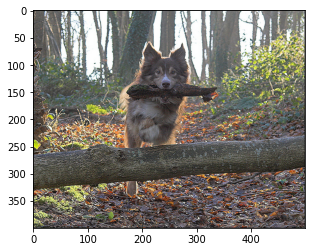

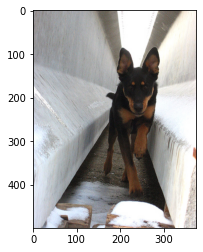

In [ ]:
# Visualize a sample of images
for i in range(2):
  plt.figure()
  image = cv2.imread(images[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  plt.imshow(image)

Feature extraction for three pre-trained models

Load the pre-trained models: VGG19, ResNet50, InceptionV3.

In [ ]:
# Load the VGG19 model
vgginput = VGG19(weights='imagenet')
# Create a new model, by removing the last layer (output layer) from the vgg19
fe_vgg_model = Model(vgginput.input, vgginput.layers[-2].output)

# Load the resnet50 model
resnet_input = ResNet50(weights='imagenet')
# Create a new model, by removing the last layer (output layer) from the resnet50
fe_resnet_model = Model(resnet_input.input, resnet_input.layers[-2].output)

# Load the inception v3 model
input_intercept = InceptionV3(weights='imagenet')
# Create a new model, by removing the last layer (output layer) from the inception v3
fe_intercept_model = Model(input_intercept.input, input_intercept.layers[-2].output)

In [ ]:
# extract features from image
def feature_extracter (pretrained_model,preprocess_input, target_size, pkl_file):
  features = {}
  directory = os.path.join('/content/drive/MyDrive/DL/Flickr8k_Dataset/Flicker8k_Dataset')
  for img_name in tqdm(os.listdir(directory)):
      # load the image from file
      img_path = directory + '/' + img_name
      image = load_img(img_path, target_size=target_size)
      # convert image pixels to numpy array
      image = img_to_array(image)
      # reshape data for model
      image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
      # preprocess image for vgg
      image = preprocess_input(image)
      # extract features
      feature = pretrained_model.predict(image, verbose=0)
      # get image ID
      image_id = img_name.split('.')[0]
      # store feature
      features[image_id] = feature  
  pickle.dump(features, open(os.path.join('/content/drive/MyDrive/DL', pkl_file), 'wb'))
  return features

In [ ]:
#extract image features using VGG19 model, and save the features
feature_extracter(fe_vgg_model,preprocess_input_vgg19, (224,224), 'images_vgg19.pkl')
with open(os.path.join('/content/drive/MyDrive/DL', 'images_vgg19.pkl'), 'rb') as vgg:
  features_vgg19= pickle.load(vgg)

In [ ]:
#extract image features using ResNet50 model, and save the features
feature_extracter(fe_resnet_model, preprocess_input_rsn, (224,224), 'images_rsn.pkl')
# store features in pickle
with open(os.path.join('/content/drive/MyDrive/DL', 'images_rsn.pkl'), 'rb') as rsn:
    features_rsn = pickle.load(rsn)

In [ ]:
len(features_rsn)

8091

In [ ]:
#extract image features using InceptionV3 model, and save the features
feature_extracter(fe_intercept_model, preprocess_input_icpt, (299,299), 'images_intercept_v3.pkl')
# store features in pickle
with open(os.path.join('/content/drive/MyDrive/DL', 'images_intercept_v3.pkl'), 'rb') as itcp:
    features_itcp = pickle.load(itcp)


In [ ]:
len(features_itcp)

8091




**Train Test Split dataset**




In [ ]:
image_ids = list(img_caption_dict.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[1:split]
test = image_ids[split:]

In [ ]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, img_caption_dict, features, tokenizer, caption_max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = img_caption_dict[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=caption_max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

Model Compilation

In [ ]:
def cp_model (shape):
  # encoder model
  # image feature layers
  inputs1 = Input(shape=shape)
  fe1 = Dropout(0.4)(inputs1)
  fe2 = Dense(256, activation='relu')(fe1)
  # sequence feature layers
  inputs2 = Input(shape=(caption_max_length,))
  se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
  se2 = Dropout(0.4)(se1)
  se3 = LSTM(256)(se2)
  # decoder model
  decoder1 = add([fe2, se3])
  decoder2 = Dense(256, activation='relu')(decoder1)
  outputs = Dense(vocab_size, activation='softmax')(decoder2)
  model = Model(inputs=[inputs1, inputs2], outputs=outputs)
  model.compile(loss='categorical_crossentropy', optimizer='adam')
  return model

In [ ]:
#Compile VGG19 model
final_model_vgg=cp_model((4096,))
# plot_model(final_model_vgg, show_shapes=True)

In [ ]:
#Compile RSN model
final_model_rsn=cp_model((2048,))
# plot_model(final_model_rsn, show_shapes=True)

In [ ]:
#Compile Inception model
final_model_itcp=cp_model((2048,))
# plot_model(final_model_itcp, show_shapes=True)

In [ ]:
# train the model
def train_model (epochs, batch_size, features, model):
  # epochs = 20
  # batch_size = 32
  steps = len(train) // batch_size
  # features= features_vgg19
  for i in range(epochs):
      # create data generator
      generator = data_generator(train, img_caption_dict, features, tokenizer, caption_max_length, vocab_size, batch_size)
      # fit for one epoch
      model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)
  return model


In [ ]:
#train model
train_model(50,32,features_rsn, final_model_rsn)

In [ ]:
#save model
final_model_rsn.save('/content/drive/MyDrive/DL/rsn_model.h5')

In [ ]:
#train model
train_model(80,32,features_itcp, final_model_itcp)

In [ ]:
#save model
final_model_itcp.save('/content/drive/MyDrive/DL/itcp_model.h5')

In [ ]:
#train model
train_model(50,32,features_vgg19, final_model_vgg)

In [ ]:
#save model
final_model_vgg.save('/content/drive/MyDrive/DL/vgg_model.h5')

Caption generation

In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
# generate caption for an image
def predict_caption(model, image, tokenizer, caption_max_length):
    # add start tag for generation process
    in_text = 'begincaption'
    # iterate over the max length of sequence
    for i in range(caption_max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], caption_max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endcaption':
            break
      
    return in_text

In [ ]:
# validate with test data
def bleuscore(model, features):
  actual, predicted = list(), list()

  for key in tqdm(test):
      # get actual caption
      captions = img_caption_dict[key]
      # predict the caption for image
      y_pred = predict_caption(model, features[key], tokenizer, caption_max_length) 
      # split into words
      actual_captions = [caption.split() for caption in captions]
      y_pred = y_pred.split()
      # append to the list
      actual.append(actual_captions)
      predicted.append(y_pred)
      
  # calcuate BLEU score
  print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
  print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

In [ ]:
#load saved models
vgg19_model = load_model('/content/drive/MyDrive/DL/vgg_model.h5')
rsn_model = load_model('/content/drive/MyDrive/DL/rsn_model.h5')
itcp_model = load_model('/content/drive/MyDrive/DL/itcp_model.h5')

In [ ]:
# bleuscore(itcp_model,features_itcp )

100%|██████████| 810/810 [06:49<00:00,  1.98it/s]


BLEU-1: 0.533877
BLEU-2: 0.307005


In [ ]:
# bleuscore(rsn_model,features_rsn )

100%|██████████| 810/810 [07:00<00:00,  1.93it/s]


BLEU-1: 0.522197
BLEU-2: 0.297896


In [ ]:
# bleuscore(vgg19_model,features_vgg19)

100%|██████████| 810/810 [06:38<00:00,  2.03it/s]


BLEU-1: 0.531817
BLEU-2: 0.301763


In [ ]:

def generate_caption(image_name,model,features):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join('/content/drive/MyDrive/DL/Flickr8k_Dataset/Flicker8k_Dataset', image_name)
    image = Image.open(img_path)
    captions = img_caption_dict[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, caption_max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
begincaption black dog and spotted dog are fighting endcaption
begincaption black dog and tri-colored dog playing with each other on the road endcaption
begincaption black dog and white dog with brown spots are staring at each other in the street endcaption
begincaption two dogs of different breeds looking at each other on the road endcaption
begincaption two dogs on pavement moving toward each other endcaption
--------------------Predicted--------------------
begincaption two dogs are playing with each other on the grass endcaption


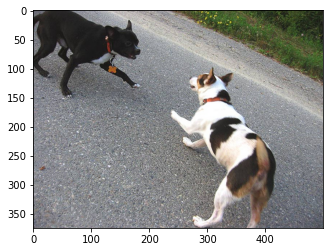

In [ ]:
generate_caption("1001773457_577c3a7d70.jpg", rsn_model,features_rsn)

---------------------Actual---------------------
begincaption black dog and spotted dog are fighting endcaption
begincaption black dog and tri-colored dog playing with each other on the road endcaption
begincaption black dog and white dog with brown spots are staring at each other in the street endcaption
begincaption two dogs of different breeds looking at each other on the road endcaption
begincaption two dogs on pavement moving toward each other endcaption
--------------------Predicted--------------------
begincaption black and white dog is running with white ball in its mouth endcaption


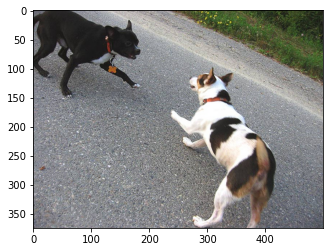

In [ ]:
generate_caption("1001773457_577c3a7d70.jpg", vgg19_model,features_vgg19)

---------------------Actual---------------------
begincaption black dog and spotted dog are fighting endcaption
begincaption black dog and tri-colored dog playing with each other on the road endcaption
begincaption black dog and white dog with brown spots are staring at each other in the street endcaption
begincaption two dogs of different breeds looking at each other on the road endcaption
begincaption two dogs on pavement moving toward each other endcaption
--------------------Predicted--------------------
begincaption two dogs are playing with each other on the pavement endcaption


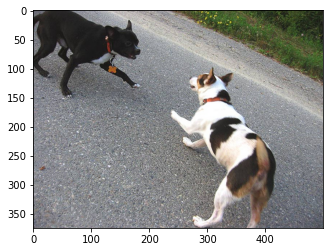

In [ ]:
generate_caption("1001773457_577c3a7d70.jpg", itcp_model,features_itcp)